In [1]:
def get_user_profile():
    profile={
        "investment_amount": float(input("Enter total investment amount: ")),
        "risk_level": input('Enter risk level (High/Moderate/Low): ').capitalize(),
        # "time_horizon": int(input('Enter time horizon in years: ')),
        "preferred_sectors": input("Enter preference of sectors(comma separated, optional): ").split(','),
    }
    profile['preferred_sectors'] = [sector.strip().capitalize() for sector in profile['preferred_sectors']]
    if profile['preferred_sectors'] == ['None'] or profile['preferred_sectors'] == ['']:
        profile['preferred_sectors'] = []  
        
    return profile

In [ ]:
# ticker_sector_map = {
#     'AAPL': 'Technology', 'GOOGL': 'Technology', 'MSFT': 'Technology', 'NVDA': 'Technology',
#     'TSLA': 'Automotive', 'F': 'Automotive',
#     'JPM': 'Financial', 'V': 'Financial', 'BAC': 'Financial',
#     'XOM': 'Energy', 'CVX': 'Energy',
#     'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare'
# }
company_info_map = {
    'AAPL': {'sector': 'Technology', 'company_name': 'Apple'},
    'GOOGL': {'sector': 'Technology', 'company_name': 'Google'},
    'MSFT': {'sector': 'Technology', 'company_name': 'Microsoft'},
    'NVDA': {'sector': 'Technology', 'company_name': 'Nvidia'},

    'TSLA': {'sector': 'Automotive', 'company_name': 'Tesla'},
    'F': {'sector': 'Automotive', 'company_name': 'Ford'},

    'JPM': {'sector': 'Financial', 'company_name': 'JPMorgan Chase'},
    'V': {'sector': 'Financial', 'company_name': 'Visa'},
    'BAC': {'sector': 'Financial', 'company_name': 'Bank of America'},

    'XOM': {'sector': 'Energy', 'company_name': 'Exxon Mobil'},
    'CVX': {'sector': 'Energy', 'company_name': 'Chevron'},

    'JNJ': {'sector': 'Healthcare', 'company_name': 'Johnson & Johnson'},
    'PFE': {'sector': 'Healthcare', 'company_name': 'Pfizer'},
    'UNH': {'sector': 'Healthcare', 'company_name': 'UnitedHealth Group'}
}

tickers = list(company_info_map.keys())

In [3]:
import yfinance as yf
import pandas as pd

def fetch_price_data(tickers, start_date= '2009-01-01', end_date= '2024-12-31'):
    raw_data= yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)
    price_data = raw_data.xs('Adj Close', level=1, axis=1)
    return price_data.dropna()

In [4]:
import numpy as np
# from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

def calculate_portfolio_metrics(price_data):

    log_returns = np.log(price_data / price_data.shift(1)).dropna()
    # z_scores = log_returns.apply(zscore)
    # log_returns_norm = log_returns[(np.abs(z_scores) < 3).all(axis=1)]

    mean_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    volatility = log_returns.std() * np.sqrt(252)
    return log_returns, mean_returns, cov_matrix, volatility


In [5]:
import matplotlib.pyplot as plt

def plot_mean_returns_by_year(log_returns):
    yearly_log_returns = log_returns.resample('Y').mean() * 252

    plt.figure(figsize=(14, 7))
   
    colors = plt.cm.tab20.colors  

    for i, ticker in enumerate(yearly_log_returns.columns):
        color = colors[i % len(colors)]
        plt.plot(
            yearly_log_returns.index.year,
            yearly_log_returns[ticker],
            label=ticker,
            color=color,
            marker='o'
        )

    plt.title('Yearly Mean Returns of Assets')
    plt.xlabel('Year')
    plt.ylabel('Mean Return (Annualized)')
    plt.legend(loc='upper left', ncol=2, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return yearly_log_returns


In [6]:
import seaborn as sns

def plot_correlation_matrix(returns):
    plt.figure(figsize=(10, 6))
    sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
    plt.title("Asset Correlation Matrix")
    plt.show()


[*********************100%***********************]  14 of 14 completed
C:\Users\DELL\AppData\Local\Temp\ipykernel_6584\2871524119.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_log_returns = log_returns.resample('Y').mean() * 252


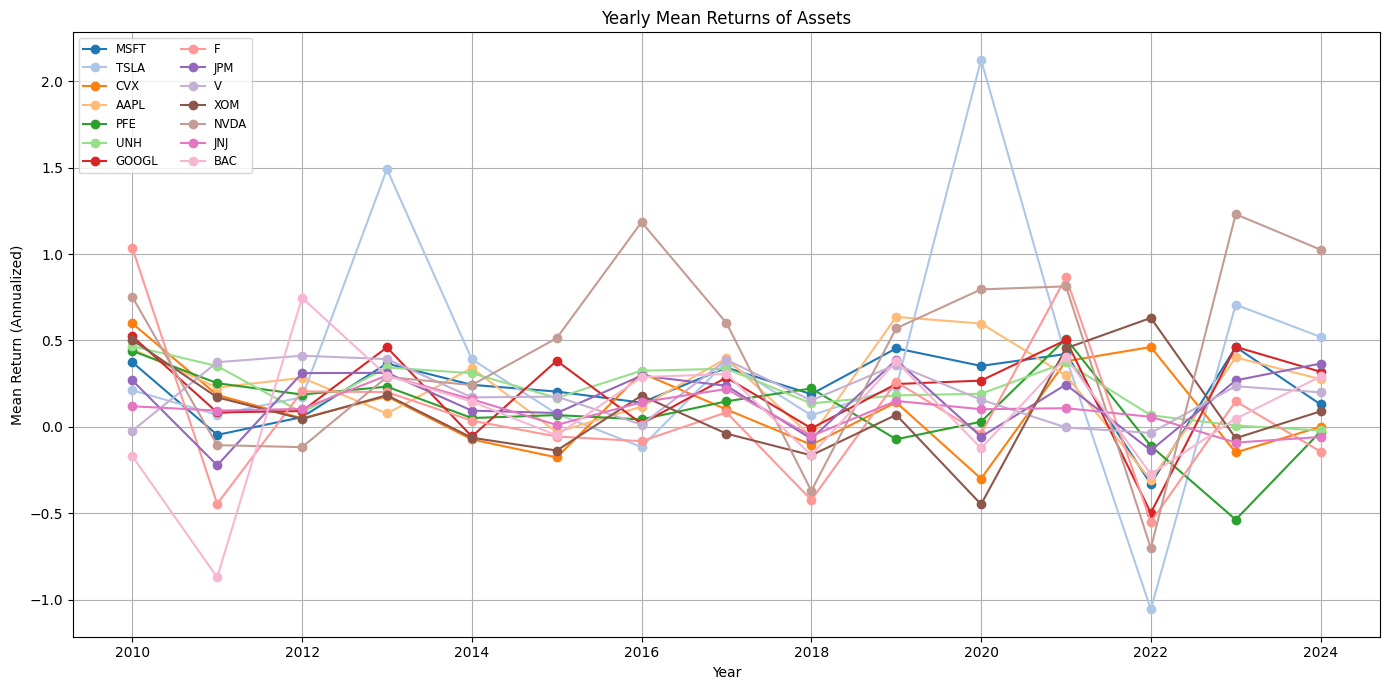

Annual Expected Returns:
 Ticker
MSFT     0.219380
TSLA     0.384466
CVX      0.090779
AAPL     0.240727
PFE      0.084946
UNH      0.213647
GOOGL    0.195135
F        0.040969
JPM      0.155285
V        0.205436
XOM      0.080470
NVDA     0.438378
JNJ      0.090231
BAC      0.092042
dtype: float64

Annual Volatility:
 Ticker
MSFT     0.256226
TSLA     0.571258
CVX      0.270369
AAPL     0.277401
PFE      0.217406
UNH      0.253502
GOOGL    0.272434
F        0.339067
JPM      0.275520
V        0.246890
XOM      0.251178
NVDA     0.450734
JNJ      0.168110
BAC      0.335008
dtype: float64


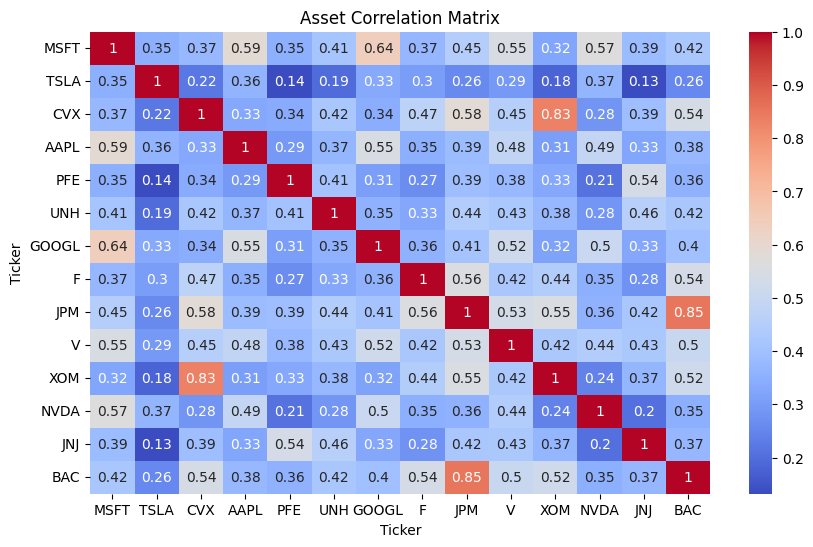

In [7]:
data = fetch_price_data(tickers)

returns, mean_returns, cov_matrix, volatility = calculate_portfolio_metrics(data)
plot_mean_returns_by_year(returns)
print("Annual Expected Returns:\n", mean_returns)
print("\nAnnual Volatility:\n", volatility)

plot_correlation_matrix(returns)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def predict_horizons(price_data, max_years=10):
    annual_trading_days = 252
    predicted_horizons = {}
    features = []
    labels = []
    valid_tickers = []

    for ticker in price_data.columns:
        prices = price_data[ticker].dropna()
        if len(prices) < 252:
            predicted_horizons[ticker] = 1
            continue
            
        returns = np.log(prices / prices.shift(1)).dropna()
        vol = returns.std() * np.sqrt(252)
        predicted_horizons[ticker] = min(max(1, int(vol * 10)), max_years)

    for ticker in price_data.columns:
        prices = price_data[ticker].dropna()
        if len(prices) < 252 * 2:  # 2 year minimum
            continue
            
        returns = np.log(prices / prices.shift(1)).dropna()
        vol = returns.std() * np.sqrt(252)
        mean_ret = returns.mean() * 252
        momentum = prices.pct_change(90).dropna().mean()

        best_year = 1
        best_cagr = -np.inf
        for y in range(1, max_years + 1):
            n = y * annual_trading_days
            if len(prices) < n:
                continue
            start_price = prices[-n]
            end_price = prices[-1]
            cagr = (end_price / start_price) ** (1/y) - 1
            if cagr > best_cagr:
                best_cagr = cagr
                best_year = y
        
        features.append([mean_ret, vol, momentum])
        labels.append(best_year)
        valid_tickers.append(ticker)

    if len(valid_tickers) >= 3:
        try:
            X = np.array(features)
            y = np.array(labels)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_scaled, y)
            
            for i, ticker in enumerate(valid_tickers):
                feat = scaler.transform([features[i]])
                pred = model.predict(feat)[0]
                predicted_horizons[ticker] = max(1, min(max_years, int(round(pred))))
        except:
            pass  # Silently fall back to volatility-based predictions

    return predicted_horizons

In [ ]:
from scipy.optimize import minimize

def optimize_portfolio(mean_returns, cov_matrix, risk_level, tickers):
    original_tickers = tickers.copy()
    if risk_level == 'Low':
        vol = np.sqrt(np.diag(cov_matrix))
        low_vol_tickers = [t for t, v in zip(tickers, vol) if v < np.percentile(vol, 50)]

        tickers = low_vol_tickers
        mean_returns = mean_returns[tickers]
        cov_matrix = cov_matrix.loc[tickers, tickers]
    num_assets=len(tickers)

    def portfolio_performance(weights):
        returns = np.dot(weights, mean_returns.values)
        risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
        return returns,risk
    
    def objective_func(weights):
        returns,risk= portfolio_performance(weights)
        
        if risk_level=='High':
            return -returns/risk
        elif risk_level=='Moderate':
            alpha= 0.5
            return  risk - 0.5 * returns
        else:
            return risk
    
    min_return_constraint = {
    'High': 0.07,
    'Moderate': 0.05,
    'Low': 0.03
    }[risk_level]

    constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_returns.values) - min_return_constraint}
    )
    
    if risk_level == 'High':
        bounds = tuple((0, 0.4) for _ in range(num_assets))
    elif risk_level == 'Moderate':
        bounds = tuple((0, 0.3) for _ in range(num_assets))
    else:  # Low
        bounds = tuple((0, 0.2) for _ in range(num_assets))

    init_weights = mean_returns.values / mean_returns.values.sum()
    # init_weights = 0.5*mean_returns[tickers].abs()/mean_returns[tickers].abs().sum() + 0.5/num_assets

    
    optimized = minimize(objective_func, init_weights, method= 'SLSQP', bounds=bounds, constraints=constraints) 

    if risk_level == 'Low':
        full_weights = np.zeros(len(original_tickers))
        ticker_indices = [original_tickers.index(t) for t in tickers]
        for i, w in zip(ticker_indices, optimized.x):
            full_weights[i] = w
        return full_weights
    else:
        return optimized.x
        

In [ ]:
profile=get_user_profile()
risk= profile['risk_level']
preferred_sectors = profile['preferred_sectors']
# horizon=profile['time_horizon']

if preferred_sectors and preferred_sectors != ['']:
    filtered_tickers=[
        t for t in tickers if company_info_map.get(t, {}).get('sector') in preferred_sectors
    ]
else:
    filtered_tickers = tickers
        
price_data = fetch_price_data(filtered_tickers)
log_returns, mean_returns, cov_matrix, _ = calculate_portfolio_metrics(price_data)

predicted_horizons=predict_horizons(price_data)
optimal_weights= optimize_portfolio(mean_returns, cov_matrix, risk, filtered_tickers)


portfolio_df = pd.DataFrame({
    'Weight': optimal_weights,
    'Predicted Horizon (yrs)': [predicted_horizons.get(t, "N/A") for t in filtered_tickers]
}, index=filtered_tickers)

print("\n Optimized Portfolio:\n")
print(portfolio_df[portfolio_df["Weight"] > 0.01].sort_values(by='Weight', ascending=False).round(4))

[*********************100%***********************]  14 of 14 completed
C:\Users\DELL\AppData\Local\Temp\ipykernel_6584\2433474903.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_price = prices[-n]
C:\Users\DELL\AppData\Local\Temp\ipykernel_6584\2433474903.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_price = prices[-1]



 Final Optimized Portfolio:

      Weight  Predicted Horizon (yrs)
MSFT  0.2000                        4
PFE   0.2000                        9
XOM   0.2000                        5
AAPL  0.1983                        2
JPM   0.1074                        1
CVX   0.0943                        4


In [28]:
def rolling_volatility(log_returns,window=21,threshold=0.3):
    rolling_vol = log_returns.rolling(window).std() * np.sqrt(252)

    plt.figure(figsize=(12,6))
    for i, col in enumerate(rolling_vol.columns):
        linestyle = '--' if i % 2 else '-'
        plt.plot(rolling_vol.index, rolling_vol[col], label=col, linestyle=linestyle)

    plt.axhline(y=threshold, color='red', linestyle='--', label='Volatility Threshold')
    plt.title(f'Rolling {window}-Day Annualized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(loc='upper right', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    latest_vol = rolling_vol.iloc[-1]

    alerts = {
        ticker: "⚠️ High Volatility"
        for ticker in rolling_vol.columns
        if rolling_vol[ticker].iloc[-1] > threshold
    }

    return alerts, latest_vol


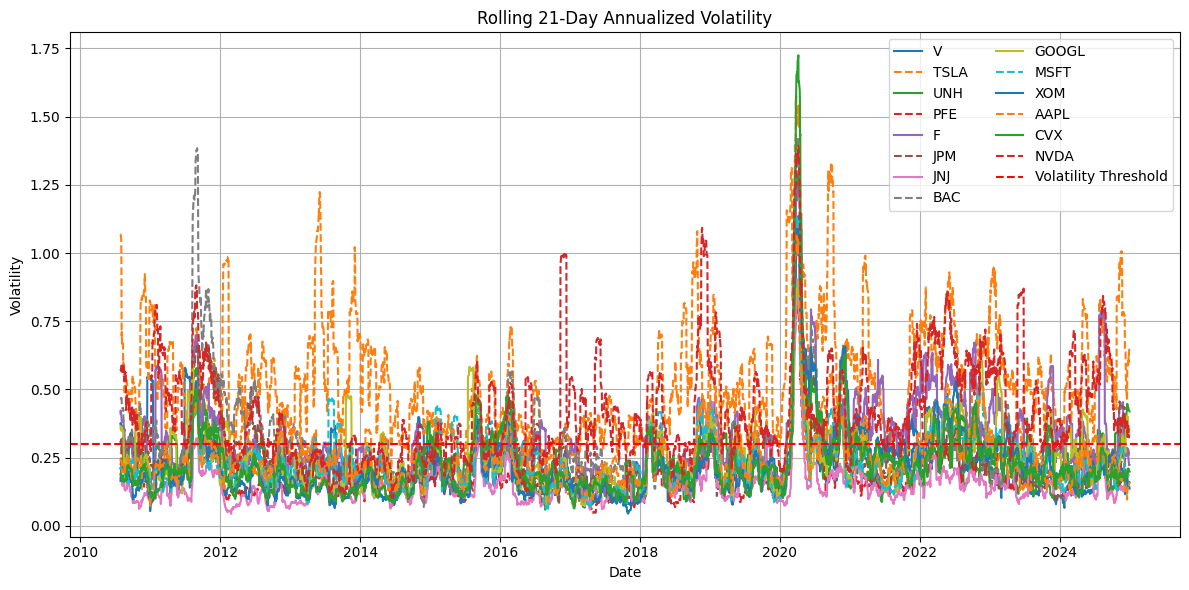

{'TSLA': '⚠️ High Volatility', 'UNH': '⚠️ High Volatility', 'GOOGL': '⚠️ High Volatility', 'NVDA': '⚠️ High Volatility'}


In [29]:
alerts,rolling_volatility= rolling_volatility(log_returns)
print(alerts)


In [13]:
def calculate_max_drawdown(price_data):
    drawdowns = {}
    for col in price_data.columns:
        prices = price_data[col]
        running_max = prices.cummax()
        drawdown = (prices - running_max) / running_max
        drawdowns[col] = drawdown.min()
    
    return drawdowns

In [14]:
drawdowns = calculate_max_drawdown(price_data)
for asset, dd in drawdowns.items():
    print(f"{asset}: Max Drawdown = {dd:.2%}")

V: Max Drawdown = -36.36%
TSLA: Max Drawdown = -73.63%
UNH: Max Drawdown = -35.90%
PFE: Max Drawdown = -54.82%
F: Max Drawdown = -68.79%
JPM: Max Drawdown = -43.63%
JNJ: Max Drawdown = -27.37%
BAC: Max Drawdown = -67.95%
GOOGL: Max Drawdown = -44.32%
MSFT: Max Drawdown = -37.15%
XOM: Max Drawdown = -62.40%
AAPL: Max Drawdown = -43.80%
CVX: Max Drawdown = -55.77%
NVDA: Max Drawdown = -66.34%


In [15]:
def compute_var(log_returns, confidence_level=0.95):
    var = log_returns.quantile(1 - confidence_level) * np.sqrt(252)
    
    print(f"Value at Risk (VaR) at {int(confidence_level*100)}% confidence level:")
    print(var.sort_values())
    
    return var

In [16]:
def compute_beta(log_returns,start_date,end_date,benchmark_ticker="^GSPC"):
    benchmark_data=yf.download(benchmark_ticker, start=start_date, end=end_date,group_by='ticker', auto_adjust=False)
    benchmark_prices= benchmark_data.xs('Adj Close', level=1, axis=1)
    benchmark_returns = np.log(benchmark_prices / benchmark_prices.shift(1)).dropna()

    benchmark_returns = benchmark_returns.rename(columns={benchmark_ticker: "Benchmark"})
    aligned_data = log_returns.join(benchmark_returns, how='inner')

    betas = {}
    for ticker in log_returns.columns:
        cov = np.cov(aligned_data[ticker], aligned_data["Benchmark"])[0][1]
        var = np.var(aligned_data["Benchmark"])
        beta = cov / var
        betas[ticker] = beta
    beta_series = pd.Series(betas).sort_values()
    print("Beta of assets relative to benchmark:")
    print(beta_series)
    
    return beta_series


In [17]:
var = compute_var(log_returns)
beta = compute_beta(log_returns,start_date= '2009-01-01', end_date= '2024-12-31')

Value at Risk (VaR) at 95% confidence level:
Ticker
TSLA    -0.832427
NVDA    -0.665729
F       -0.508225
BAC     -0.494913
AAPL    -0.419428
JPM     -0.408792
GOOGL   -0.403983
CVX     -0.398078
MSFT    -0.390363
XOM     -0.369260
V       -0.366316
UNH     -0.365971
PFE     -0.324772
JNJ     -0.245076
Name: 0.050000000000000044, dtype: float64


[*********************100%***********************]  1 of 1 completed

Beta of assets relative to benchmark:
JNJ      0.558113
PFE      0.655345
UNH      0.867002
XOM      0.873307
CVX      1.001508
V        1.032644
GOOGL    1.101715
AAPL     1.103559
MSFT     1.131396
JPM      1.182452
F        1.198037
BAC      1.369336
TSLA     1.451652
NVDA     1.645730
dtype: float64


In [ ]:
from newsapi import NewsApiClient
import torch
from transformers import pipeline
from time import sleep
import datetime
import re

newsapi = NewsApiClient(api_key='d06e74ea9c4a4bed891871a26af39415')

def fetch_news_headlines(ticker,company_name,sector,max_articles=20):
    query = f'"{company_name}" OR "{ticker}" OR "{company_name} stock" OR "{ticker} stock" OR "{sector}"'

    
    today = datetime.datetime.now()
    from_date = (today - datetime.timedelta(days=15)).strftime('%Y-%m-%d')

    articles = newsapi.get_everything(
        q=query,
        from_param=from_date,
        language='en',
        sort_by='relevancy',
        page_size=max_articles
    )
    def is_relevant(headline, ticker, company_name, sector):
        score = 0
        headline_lower = headline.lower()
        
        if re.search(r'\b' + re.escape(ticker.lower()) + r'\b', headline_lower):
            score += 3
        if re.search(r'\b' + re.escape(company_name.lower()) + r'\b', headline_lower):
            score += 2
        if re.search(r'\b' + re.escape(sector.lower()) + r'\b', headline_lower):
            score += 1

        return score >= 1 
    
    headlines = [article['title'] for article in articles['articles']]
    headlines = [h for h in headlines if is_relevant(h, ticker, company_name, sector)]
    return headlines


finbert_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def analyze_sentiment(headlines):
    sentiments = []
    for headline in headlines:
        try:
            result=finbert_pipeline(headline)[0]
            label=result['label'].lower()
            sentiments.append(label)
        except Exception as e:
            print(f"Error analyzing headline: {headline}\n{e}")
        sleep(0.5)
    return sentiments

def compute_sentiment_score(company_info_map):
    score_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    sentiment_scores={}

    for ticker, info in company_info_map.items():
        sector = info['sector']
        company_name = info['company_name']
        headlines = fetch_news_headlines(ticker, company_name, sector)
        sentiments = analyze_sentiment(headlines)
        if sentiments:
            numerical_scores = [score_map[s] for s in sentiments if s in score_map]
            sentiment_score = round(sum(numerical_scores) / len(numerical_scores), 3)
        else:
            sentiment_score = 0.0
        print(f"Sentiment Score for {ticker}: {sentiment_score}")
        sentiment_scores[ticker] = sentiment_score
        # sentiment_scores[ticker] = {
        #     'sentiment_score': sentiment_score,
        #     'headlines': headlines,
        #     'sentiments': sentiments
        # }

    return sentiment_scores

Device set to use cpu


In [40]:
scores = compute_sentiment_score(company_info_map)
# print("\nFinal Sentiment Scores:", scores)

Sentiment Score for AAPL: -0.25
Sentiment Score for GOOGL: 0.0
Sentiment Score for MSFT: 0.667
Sentiment Score for NVDA: 0.5
Sentiment Score for TSLA: -0.2
Sentiment Score for F: 0.0
Sentiment Score for JPM: 0.0
Sentiment Score for V: 0.0
Sentiment Score for BAC: 0.0
Sentiment Score for XOM: 0.0
Sentiment Score for CVX: 0.0
Sentiment Score for JNJ: -1.0
Sentiment Score for PFE: -0.667
Sentiment Score for UNH: -0.714


In [44]:
def normalize(metric):
    series = pd.Series(metric)
    normalized_series = (series - series.min()) / (series.max() - series.min() + 1e-6)
    return normalized_series.to_dict()

def rebalance_weights(base_weights,tickers,rolling_volatility, max_drawdowns, var, beta, sentiment_score):
    adjusted_weights={}
    vol_norm= normalize(rolling_volatility)
    dd_norm = normalize({k: -v for k, v in max_drawdowns.items()})
    var_norm = normalize({k: -v for k, v in var.items()})
    beta_norm= normalize(beta)
    sentiment_norm = {k: 1 - ((v + 1) / 2) for k, v in sentiment_score.items()}

    risk_score={}
    for i,ticker in enumerate(tickers):
        risk_score[ticker]=(
            0.25 * vol_norm[ticker] +
            0.2 * dd_norm[ticker] +
            0.2 * var_norm[ticker] +
            0.15 * beta_norm[ticker] + 
            0.2 * sentiment_norm[ticker]
        )
        penalty= 1 - risk_score[ticker]
        adjusted= base_weights[ticker] * penalty
        adjusted_weights[ticker]= adjusted

    total = sum(adjusted_weights.values())
    for ticker in adjusted_weights:
        adjusted_weights[ticker] /= total
        
    return adjusted_weights

In [49]:
adjusted_weights = rebalance_weights(portfolio_df["Weight"],tickers, rolling_volatility, drawdowns, var, beta, scores)

portfolio_df['Adjusted Weight'] = pd.Series(adjusted_weights)

result_df = portfolio_df[portfolio_df['Adjusted Weight'] > 0.01].sort_values(by='Adjusted Weight', ascending=False).round(4)


print("\n Final Optimized Portfolio:\n")
print(result_df[['Adjusted Weight', 'Predicted Horizon (yrs)']])



 Final Optimized Portfolio:

      Adjusted Weight  Predicted Horizon (yrs)
MSFT           0.2287                        4
XOM            0.1979                        5
AAPL           0.1947                        2
PFE            0.1831                        9
JPM            0.1063                        1
CVX            0.0892                        4
